In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with h5py.File('furnace_data_1kmu_1e4_nozero.hdf5', "r") as infile:
    preds = Tensor(infile['preds'][()])
    targs = Tensor(infile['targs'][()])

In [4]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [5]:
volume = get_volume()

In [6]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([4., 4.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([4., 4.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([4., 4.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([4., 4.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (

# Vars

In [7]:
df = pd.DataFrame(targs.numpy(), columns=['gen_target'])

In [8]:
from tomopt.plotting.appearance import *

def plot_pred(pred, targ):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        print("Zero-ordered target layer ID (including ladel bottom layer):", np.floor((targ-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
        plt.show()

In [9]:
ladel_removed = preds[:,1:,1:-1,1:-1]

In [10]:
def get_3d_avg(data):
    return F.avg_pool3d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [11]:
def get_3d_gauss(data):
    gauss = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data =Tensor([[[[[1,2,1],[2,4,2],[1,2,1]],[[2,4,2],[4,8,4],[2,4,2]], [[1,2,1],[2,4,2],[1,2,1]]]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/gauss.weight.sum()

In [12]:
def get_layer_avgs(data):
    return data.mean((-1,-2))

In [13]:
def get_max_sub_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes-mins

In [14]:
def get_max_div_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes/mins

In [15]:
def get_edge_det(data, kernel):
    edge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    edge.weight.data = Tensor([[kernel]])
    edge.requires_grad_(False)
    return edge(data[:,None]).squeeze()

In [16]:
def get_1d_gauss(data):
    gauss = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data = Tensor([[[2,4,2]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/8

In [17]:
def get_1d_avg(data):
    return F.avg_pool1d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [18]:
def get_probs(data):
    return F.softmax(data, dim=-1)

In [19]:
def targ2class(targs, volume):
    return torch.div((targs-volume.get_passive_z_range()[0]), volume.passive_size, rounding_mode='floor')-1  # -1 due to flooring of mat_z during voxelisation

In [76]:
def get_losses(probs, class_targs, pred_start, test_id=None):
    ints = torch.arange(pred_start, pred_start+probs.size(1))
    mses = 100*torch.softmax((class_targs-ints).abs(), dim=-1)
    losses = mses*probs
    if test_id is not None:
        print('targ ID', class_targs[test_id])
        print('probs', probs[test_id])
        print('ints', ints)
        print('mses', mses[test_id])
        print('int losses', losses[test_id])
    return losses.sum(-1)

In [77]:
def get_loss(probs, class_targs, pred_start, test_id=None):
    return get_losses(probs, class_targs, pred_start, test_id).mean()

In [78]:
def score_data(logits, targs, pred_start, volume=volume, test_id=None):
    probs = get_probs(logits)
    ctargs = targ2class(targs, volume=volume)
    print(get_loss(probs, ctargs, pred_start, test_id=test_id))

# Tests

In [50]:
test_id=0

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


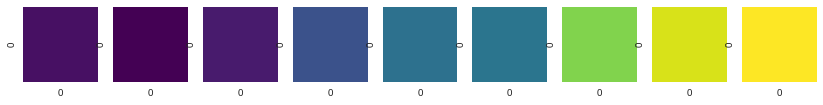

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


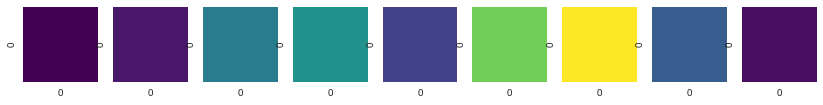

tensor(11.0924)
tensor(11.0961)
targ ID tensor([5.])
probs tensor([0.1107, 0.1108, 0.1112, 0.1113, 0.1109, 0.1116, 0.1118, 0.1110, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5441, 1.3046, 0.4815, 0.1773, 0.0650, 0.1778, 0.4842, 1.3074, 3.5454])
tensor(11.1001)


(None, None, None)

In [51]:
# max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


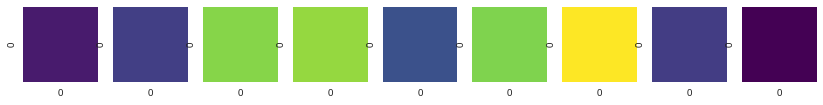

tensor(9.5695)
tensor(9.6330)
targ ID tensor([5.])
probs tensor([0.0862, 0.0921, 0.1339, 0.1359, 0.0956, 0.1330, 0.1492, 0.0916, 0.0826])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.7587, 1.0840, 0.5799, 0.2166, 0.0560, 0.2119, 0.6462, 1.0791, 2.6431])
tensor(9.7183)


(None, None, None)

In [52]:
# max/min
x = get_layer_avgs(ladel_removed)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


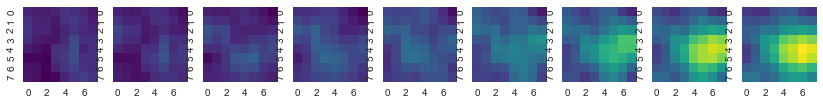

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


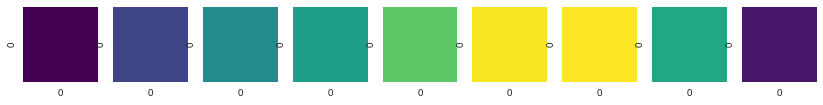

tensor(11.0886)
tensor(11.0911)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1111, 0.1111, 0.1113, 0.1115, 0.1115, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5438, 1.3055, 0.4812, 0.1771, 0.0652, 0.1776, 0.4829, 1.3090, 3.5453])
tensor(11.0940)


(None, None, None)

In [53]:
# pre-avg 3d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


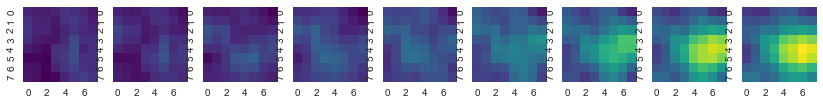

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


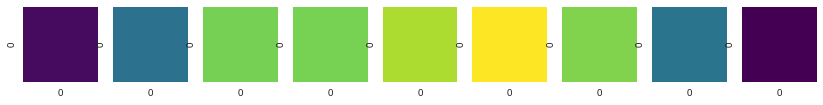

tensor(9.2971)
tensor(9.3466)
targ ID tensor([5.])
probs tensor([0.0871, 0.1012, 0.1214, 0.1216, 0.1259, 0.1329, 0.1223, 0.1017, 0.0860])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.7869, 1.1919, 0.5258, 0.1937, 0.0738, 0.2118, 0.5296, 1.1979, 2.7526])
tensor(9.4284)


(None, None, None)

In [54]:
# pre-avg 3d max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


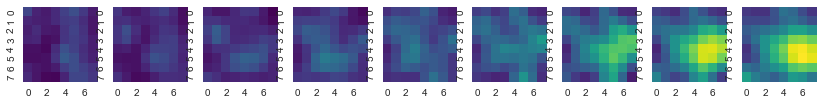

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


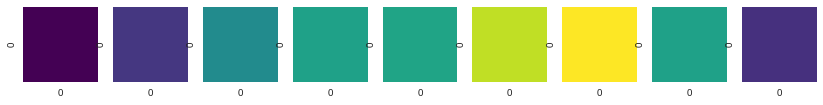

tensor(11.0910)
tensor(11.0942)
targ ID tensor([5.])
probs tensor([0.1107, 0.1108, 0.1111, 0.1112, 0.1112, 0.1115, 0.1116, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5425, 1.3049, 0.4813, 0.1772, 0.0652, 0.1776, 0.4833, 1.3091, 3.5464])
tensor(11.0978)


(None, None, None)

In [55]:
# pre-gaiss 3d max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


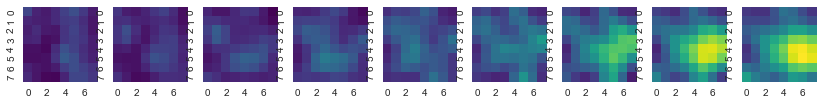

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


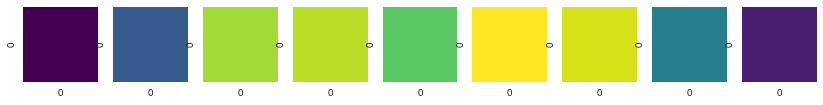

tensor(9.4706)
tensor(9.5414)
targ ID tensor([5.])
probs tensor([0.0833, 0.0953, 0.1250, 0.1270, 0.1182, 0.1335, 0.1296, 0.1016, 0.0867])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.6649, 1.1221, 0.5414, 0.2024, 0.0693, 0.2127, 0.5613, 1.1962, 2.7737])
tensor(9.6441)


(None, None, None)

In [56]:
# pre-gauss 3d max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


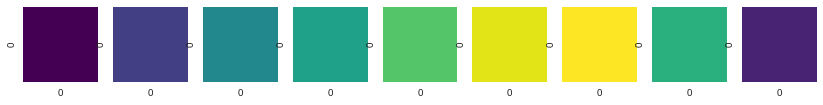

tensor(11.0895)
tensor(11.0920)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1111, 0.1111, 0.1113, 0.1115, 0.1115, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5436, 1.3053, 0.4811, 0.1771, 0.0652, 0.1776, 0.4829, 1.3094, 3.5459])
tensor(11.0948)


(None, None, None)

In [57]:
# avg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


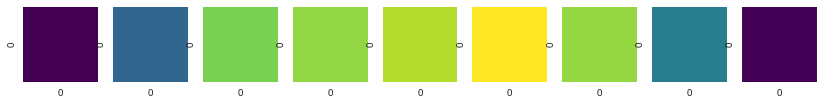

tensor(9.3387)
tensor(9.3930)
targ ID tensor([5.])
probs tensor([0.0862, 0.0992, 0.1211, 0.1230, 0.1256, 0.1320, 0.1233, 0.1032, 0.0864])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.7575, 1.1677, 0.5246, 0.1960, 0.0736, 0.2104, 0.5339, 1.2154, 2.7666])
tensor(9.4795)


(None, None, None)

In [58]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


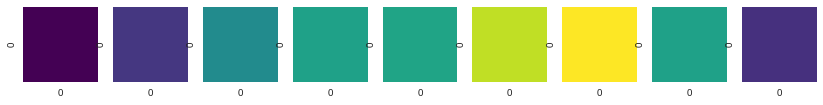

tensor(11.0910)
tensor(11.0942)
targ ID tensor([5.])
probs tensor([0.1107, 0.1108, 0.1111, 0.1112, 0.1112, 0.1115, 0.1116, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5425, 1.3049, 0.4813, 0.1772, 0.0652, 0.1776, 0.4833, 1.3091, 3.5464])
tensor(11.0978)


(None, None, None)

In [59]:
# gaussg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


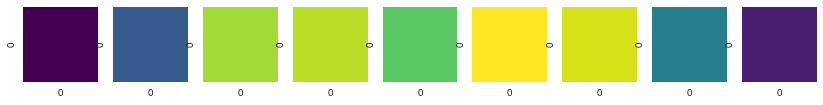

tensor(9.4706)
tensor(9.5414)
targ ID tensor([5.])
probs tensor([0.0833, 0.0953, 0.1250, 0.1270, 0.1182, 0.1335, 0.1296, 0.1016, 0.0867])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.6649, 1.1221, 0.5414, 0.2024, 0.0693, 0.2127, 0.5613, 1.1962, 2.7737])
tensor(9.6441)


(None, None, None)

In [60]:
# gauss 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


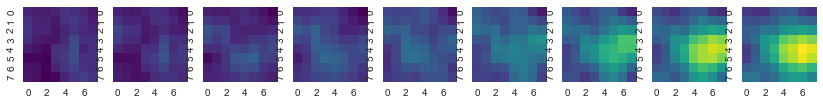

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


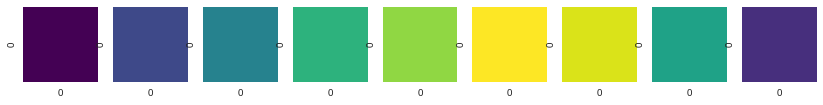

tensor(11.0898)
tensor(11.0917)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1110, 0.1112, 0.1113, 0.1114, 0.1114, 0.1111, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5447, 1.3058, 0.4810, 0.1772, 0.0653, 0.1776, 0.4825, 1.3086, 3.5477])
tensor(11.0941)


(None, None, None)

In [61]:
# pre-avg 3d avg 1d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


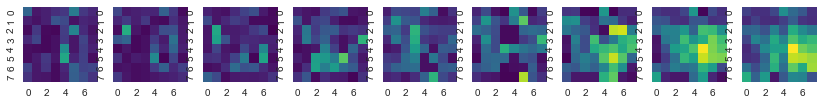

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


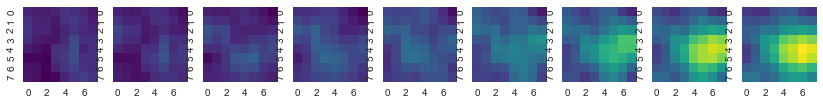

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


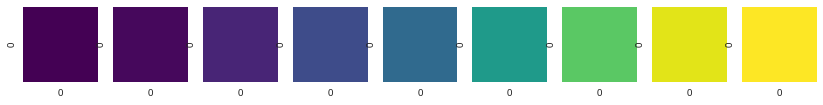

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


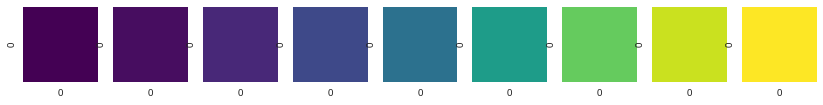

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


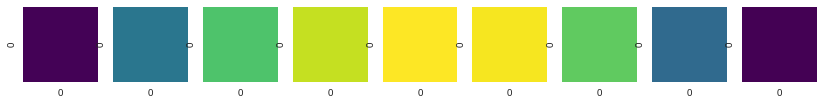

tensor(9.4200)
tensor(9.4544)
targ ID tensor([5.])
probs tensor([0.0894, 0.1031, 0.1165, 0.1250, 0.1291, 0.1285, 0.1180, 0.1012, 0.0892])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.8625, 1.2143, 0.5046, 0.1991, 0.0757, 0.2047, 0.5109, 1.1916, 2.8557])
tensor(9.5182)


(None, None, None)

In [62]:
# pre-avg 3d avg 1d max/min
plot_pred(ladel_removed[0], targs[0])
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

## Ridge -1,x,-1

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


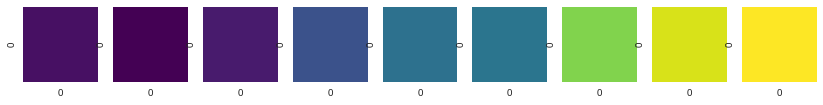

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


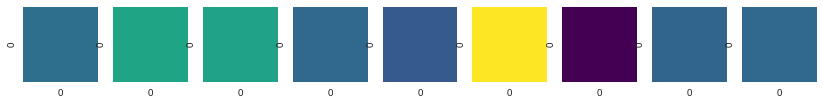

tensor(11.1023)
tensor(11.0996)
targ ID tensor([5.])
probs tensor([0.1110, 0.1113, 0.1113, 0.1110, 0.1109, 0.1119, 0.1105, 0.1110, 0.1110])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5536, 1.3110, 0.4822, 0.1769, 0.0650, 0.1784, 0.4787, 1.3066, 3.5523])
tensor(11.0971)


(None, None, None)

In [63]:
# Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


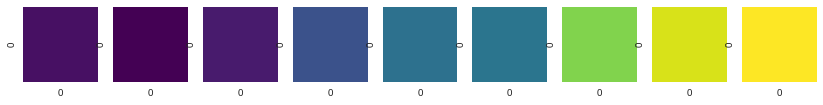

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


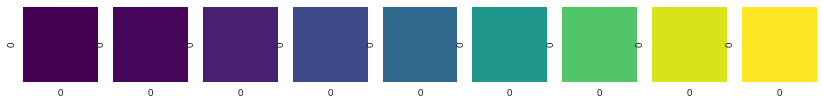

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


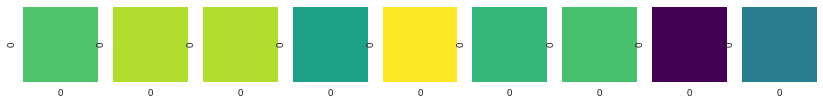

tensor(11.1078)
tensor(11.1057)
targ ID tensor([5.])
probs tensor([0.1111, 0.1112, 0.1112, 0.1111, 0.1113, 0.1111, 0.1111, 0.1108, 0.1110])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5575, 1.3096, 0.4818, 0.1770, 0.0652, 0.1771, 0.4814, 1.3047, 3.5528])
tensor(11.1036)


(None, None, None)

In [64]:
# 1d avg Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


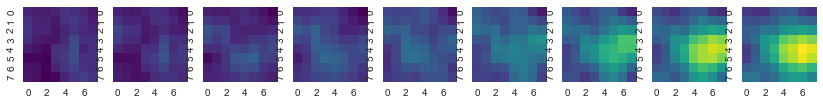

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


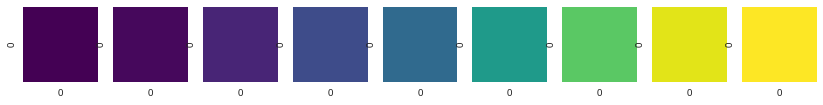

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


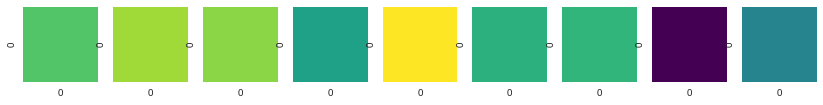

tensor(11.1078)
tensor(11.1056)
targ ID tensor([5.])
probs tensor([0.1112, 0.1112, 0.1112, 0.1111, 0.1113, 0.1111, 0.1111, 0.1108, 0.1110])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5578, 1.3096, 0.4817, 0.1770, 0.0652, 0.1771, 0.4813, 1.3046, 3.5534])
tensor(11.1034)


(None, None, None)

In [65]:
# 3d avg Ridge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


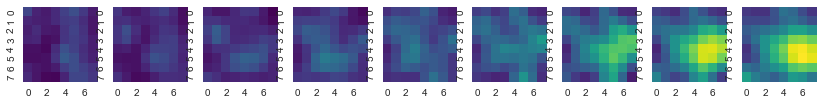

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


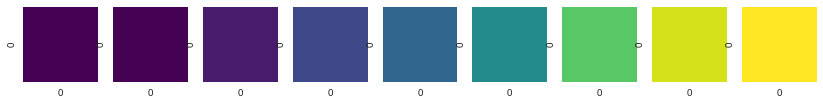

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


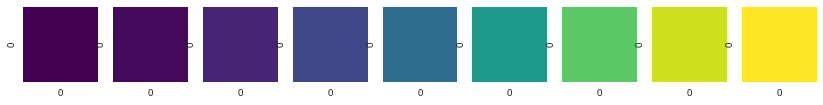

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


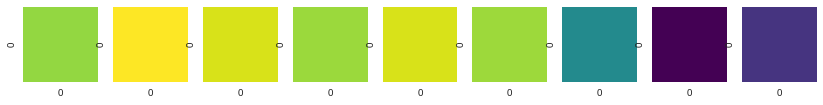

tensor(11.1084)
tensor(11.1064)
targ ID tensor([5.])
probs tensor([0.1112, 0.1112, 0.1112, 0.1112, 0.1112, 0.1112, 0.1111, 0.1109, 0.1110])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5579, 1.3094, 0.4816, 0.1771, 0.0652, 0.1771, 0.4811, 1.3061, 3.5516])
tensor(11.1044)


(None, None, None)

In [88]:
# 3d avg 1d avg Ridge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


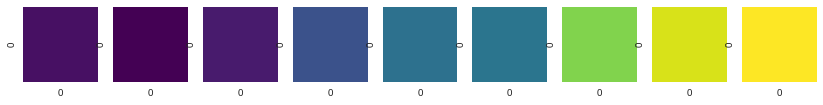

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


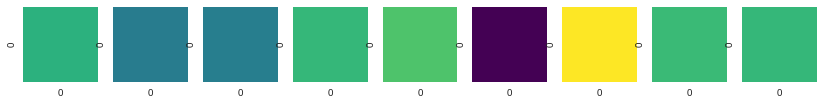

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


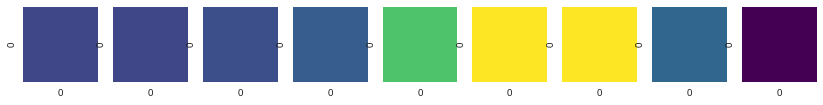

tensor(11.1014)
tensor(11.1047)
targ ID tensor([5.])
probs tensor([0.1108, 0.1108, 0.1108, 0.1109, 0.1115, 0.1119, 0.1119, 0.1109, 0.1105])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5459, 1.3044, 0.4800, 0.1767, 0.0654, 0.1783, 0.4847, 1.3063, 3.5362])
tensor(11.1080)


(None, None, None)

In [67]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


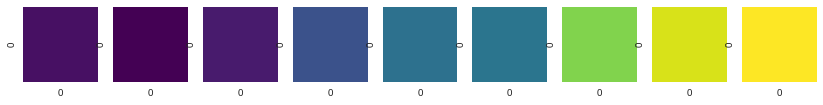

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


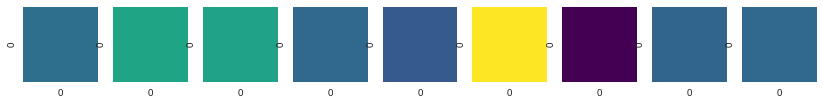

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


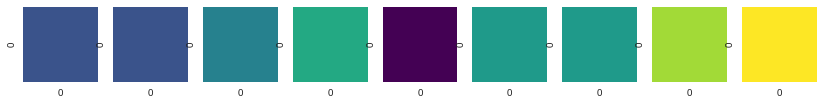

tensor(10.0458)
tensor(10.0601)
targ ID tensor([5.])
probs tensor([0.0130, 0.0130, 0.0314, 0.0714, 0.0037, 0.0524, 0.0524, 0.2553, 0.5074])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([4.1653e-01, 1.5323e-01, 1.3590e-01, 1.1371e-01, 2.1598e-03, 8.3563e-02,
        2.2715e-01, 3.0061e+00, 1.6240e+01])
tensor(10.5052)


(None, None, None)

In [89]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


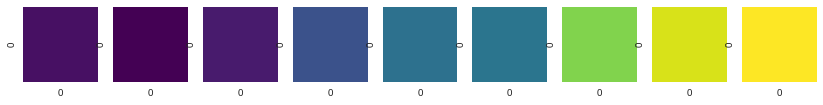

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


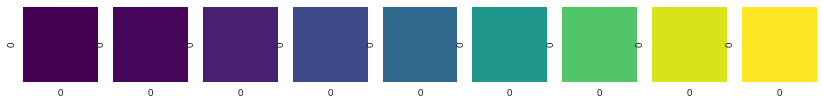

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


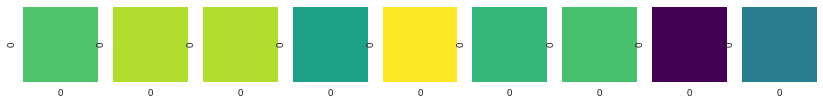

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


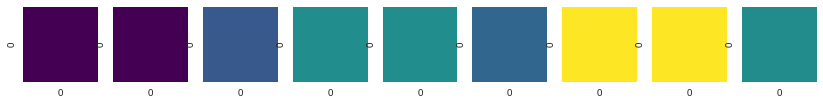

tensor(11.1048)
tensor(11.1056)
targ ID tensor([5.])
probs tensor([0.1110, 0.1110, 0.1111, 0.1111, 0.1111, 0.1111, 0.1113, 0.1113, 0.1111])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5525, 1.3069, 0.4811, 0.1771, 0.0651, 0.1770, 0.4819, 1.3100, 3.5566])
tensor(11.1065)


(None, None, None)

In [69]:
# 1d avg Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


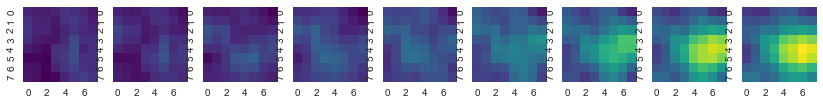

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


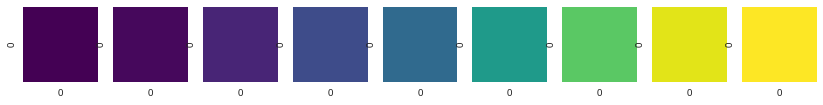

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


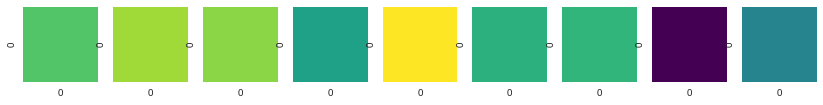

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


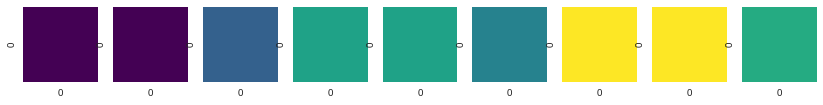

tensor(11.1044)
tensor(11.1053)
targ ID tensor([5.])
probs tensor([0.1110, 0.1110, 0.1111, 0.1111, 0.1111, 0.1111, 0.1112, 0.1112, 0.1111])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5522, 1.3068, 0.4811, 0.1771, 0.0651, 0.1770, 0.4819, 1.3098, 3.5573])
tensor(11.1063)


(None, None, None)

In [70]:
# 3d avg Ridge max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


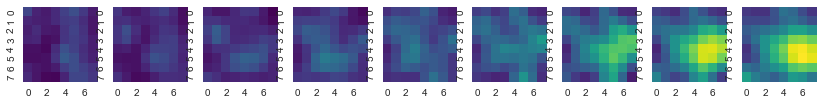

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


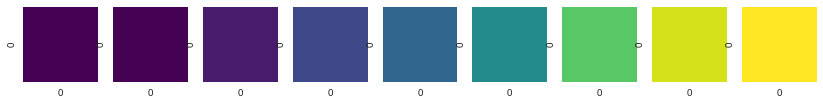

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


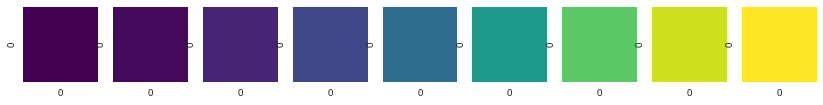

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


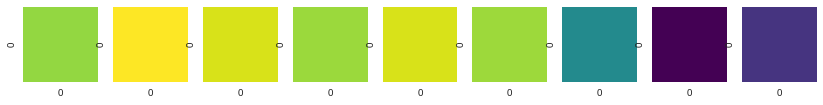

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


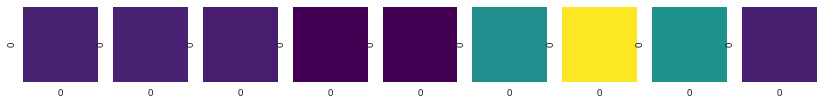

tensor(11.1070)
tensor(11.1075)
targ ID tensor([5.])
probs tensor([0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1112, 0.1113, 0.1112, 0.1111])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5552, 1.3079, 0.4811, 0.1770, 0.0651, 0.1771, 0.4820, 1.3089, 3.5551])
tensor(11.1080)


(None, None, None)

In [79]:
# 3d avg 1d avg Ridge max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


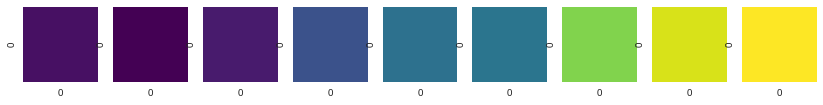

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


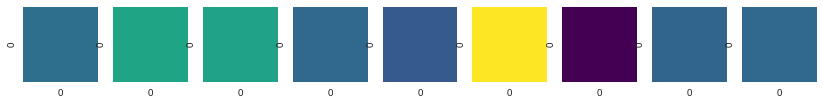

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


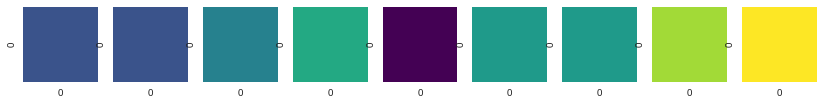

tensor(10.0458)
tensor(10.0601)
targ ID tensor([5.])
probs tensor([0.0130, 0.0130, 0.0314, 0.0714, 0.0037, 0.0524, 0.0524, 0.2553, 0.5074])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([4.1653e-01, 1.5323e-01, 1.3590e-01, 1.1371e-01, 2.1598e-03, 8.3563e-02,
        2.2715e-01, 3.0061e+00, 1.6240e+01])
tensor(10.5052)


(None, None, None)

In [87]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


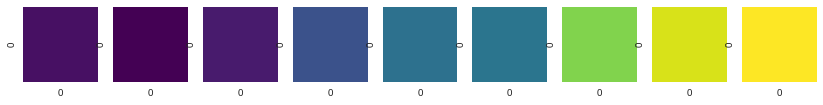

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


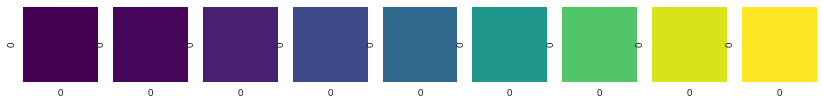

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


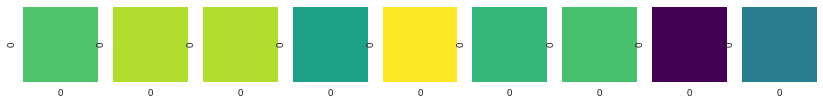

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


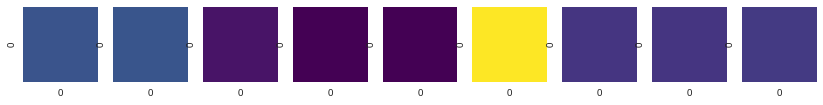

tensor(8.1784)
tensor(7.0196)
targ ID tensor([5.])
probs tensor([4.8617e-10, 4.9940e-10, 1.1528e-12, 2.4527e-13, 2.4527e-13, 1.0000e+00,
        2.1007e-11, 2.1007e-11, 3.2773e-11])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.5561e-08, 5.8802e-09, 4.9934e-12, 3.9085e-13, 1.4378e-13, 1.5935e+00,
        9.0995e-11, 2.4735e-10, 1.0490e-09])
tensor(6.1502)


(None, None, None)

In [81]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


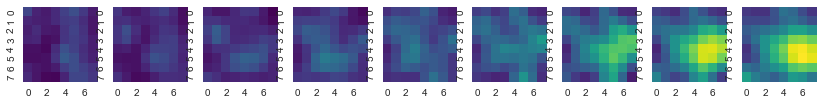

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


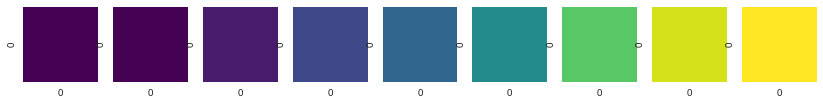

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


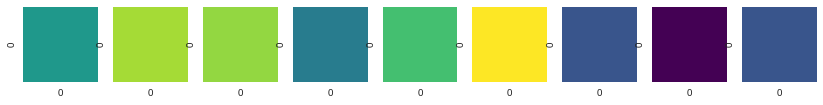

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


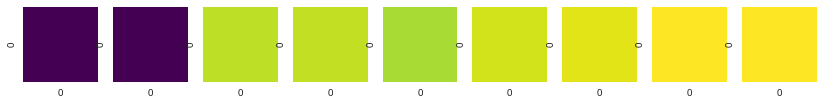

tensor(6.7431)
tensor(5.8699)
targ ID tensor([5.])
probs tensor([9.6757e-15, 9.6757e-15, 1.8267e-02, 2.2974e-02, 6.3490e-03, 4.6500e-02,
        1.0358e-01, 4.0117e-01, 4.0117e-01])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.0969e-13, 1.1393e-13, 7.9128e-02, 3.6610e-02, 3.7219e-03, 7.4100e-02,
        4.4866e-01, 4.7236e+00, 1.2840e+01])
tensor(5.2757)


(None, None, None)

In [83]:
# 3d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


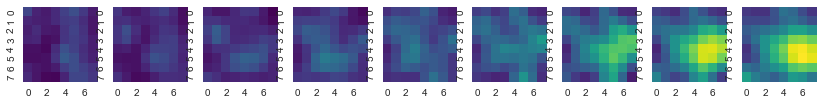

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


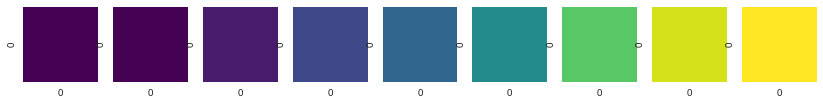

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


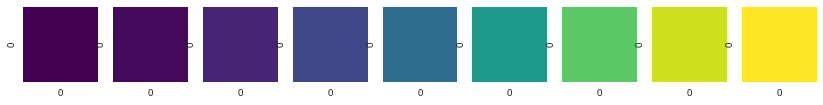

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


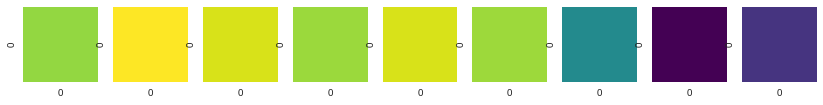

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


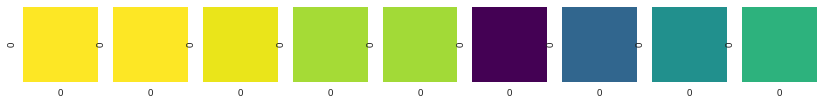

tensor(7.6510)
tensor(6.5986)
targ ID tensor([5.])
probs tensor([0.2085, 0.2085, 0.1857, 0.1328, 0.1311, 0.0077, 0.0224, 0.0395, 0.0639])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([6.6725, 2.4547, 0.8046, 0.2116, 0.0768, 0.0122, 0.0971, 0.4650, 2.0453])
tensor(5.7056)


(None, None, None)

In [85]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

In [92]:
test_id=0

Zero-ordered target layer ID (including ladel bottom layer): tensor([1.])


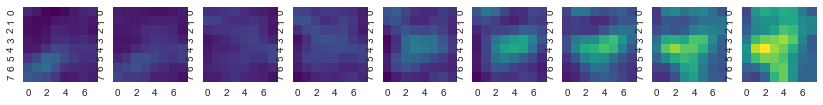

Zero-ordered target layer ID (including ladel bottom layer): tensor([1.])


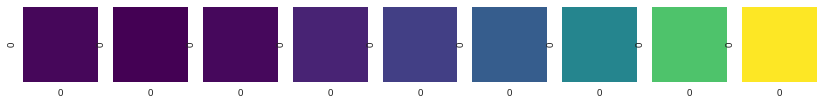

Zero-ordered target layer ID (including ladel bottom layer): tensor([1.])


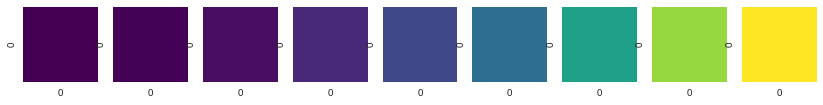

Zero-ordered target layer ID (including ladel bottom layer): tensor([1.])


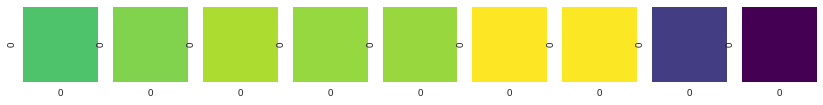

Zero-ordered target layer ID (including ladel bottom layer): tensor([1.])


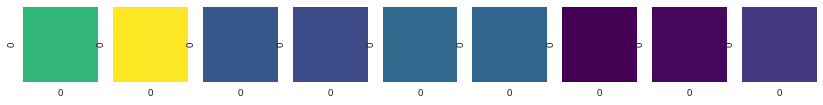

tensor(5.9593)
tensor(4.6849)
targ ID tensor([1.])
probs tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([2.1208e-02, 5.7649e-02, 1.5671e-01, 4.2597e-01, 1.1579e+00, 3.1475e+00,
        8.5559e+00, 2.3257e+01, 6.3220e+01])
int losses tensor([0.0000, 0.0576, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor(3.7072)


(None, None, None)

In [91]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)*1e2
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


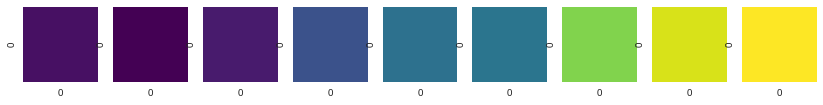

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


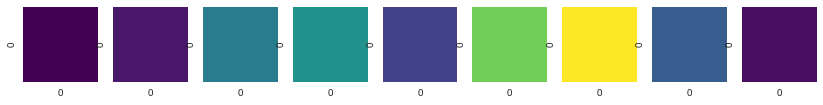

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


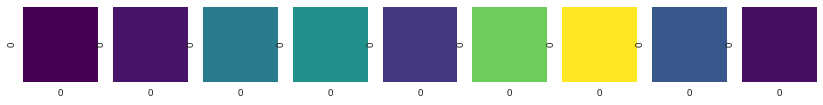

tensor(10.5384)
tensor(10.6484)
targ ID tensor([5.])
probs tensor([0.0997, 0.1012, 0.1124, 0.1155, 0.1044, 0.1249, 0.1335, 0.1079, 0.1006])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.1906, 1.1919, 0.4868, 0.1840, 0.0612, 0.1991, 0.5782, 1.2700, 3.2202])
tensor(10.7698)


(None, None, None)

In [93]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,32,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


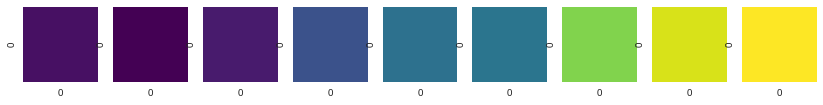

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


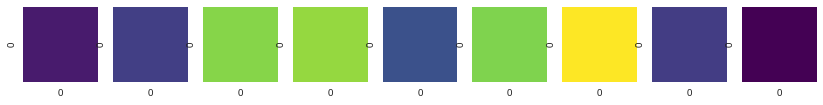

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


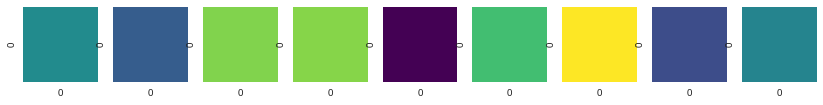

tensor(10.1362)
tensor(10.1383)
targ ID tensor([5.])
probs tensor([0.0965, 0.0757, 0.1476, 0.1488, 0.0521, 0.1278, 0.1883, 0.0703, 0.0929])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.0889, 0.8915, 0.6395, 0.2371, 0.0305, 0.2037, 0.8155, 0.8275, 2.9727])
tensor(10.1264)


(None, None, None)

In [95]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

In [ ]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

In [ ]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,32,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

In [ ]:
-1,0,1
-2,0,2
1,-4,1 (zero-cross)

## Directed edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


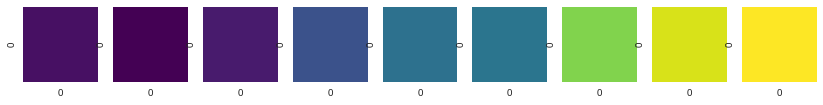

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


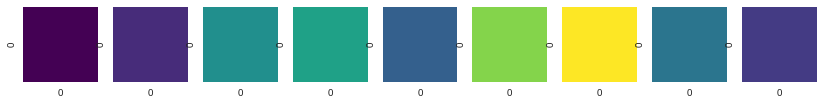

tensor(11.0815)
tensor(11.0868)
targ ID tensor([5.])
probs tensor([0.1106, 0.1107, 0.1112, 0.1113, 0.1110, 0.1116, 0.1118, 0.1111, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5396, 1.3039, 0.4816, 0.1773, 0.0650, 0.1778, 0.4843, 1.3077, 3.5463])
tensor(11.0932)


(None, None, None)

In [96]:
# Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


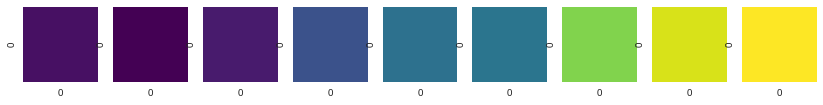

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


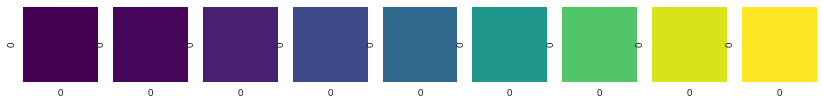

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


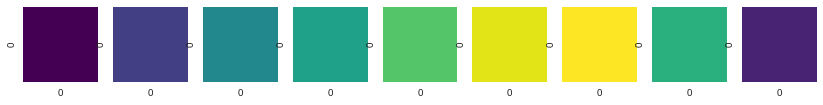

tensor(11.0866)
tensor(11.0891)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1111, 0.1111, 0.1113, 0.1115, 0.1115, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5436, 1.3053, 0.4811, 0.1771, 0.0652, 0.1776, 0.4829, 1.3094, 3.5459])
tensor(11.0923)


(None, None, None)

In [97]:
# 1d avg Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


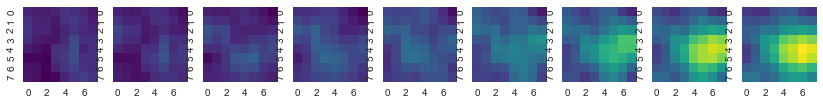

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


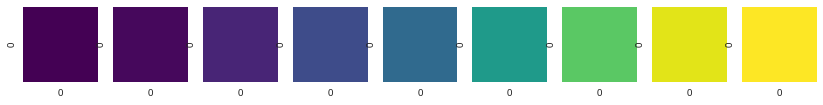

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


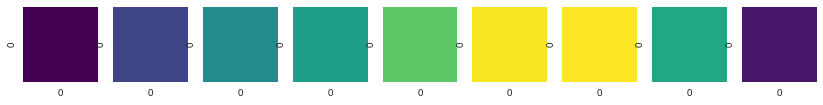

tensor(11.0856)
tensor(11.0881)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1111, 0.1111, 0.1113, 0.1115, 0.1115, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5438, 1.3055, 0.4812, 0.1771, 0.0652, 0.1776, 0.4829, 1.3090, 3.5453])
tensor(11.0913)


(None, None, None)

In [98]:
# 3d avg Edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


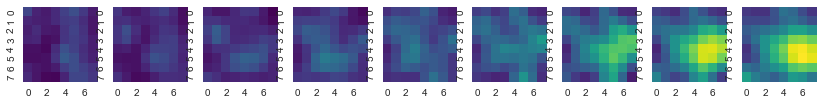

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


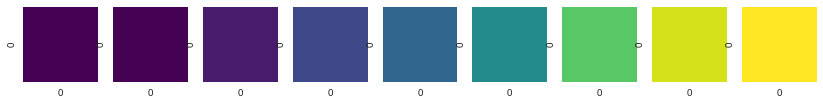

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


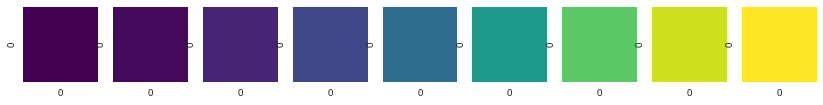

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


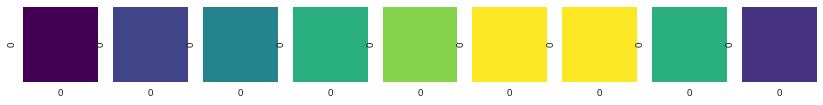

tensor(11.0880)
tensor(11.0901)
targ ID tensor([5.])
probs tensor([0.1107, 0.1109, 0.1110, 0.1112, 0.1113, 0.1114, 0.1114, 0.1112, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5444, 1.3055, 0.4810, 0.1772, 0.0652, 0.1776, 0.4827, 1.3091, 3.5476])
tensor(11.0929)


(None, None, None)

In [99]:
# 3d avg 1d avg Edge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


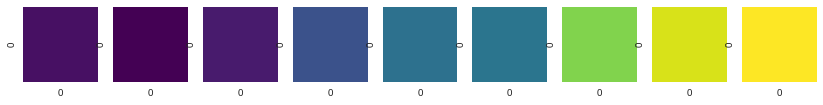

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


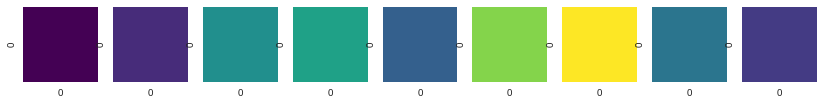

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


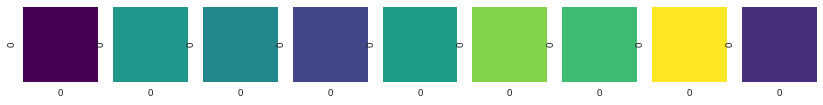

tensor(11.0925)
tensor(11.0951)
targ ID tensor([5.])
probs tensor([0.1107, 0.1111, 0.1111, 0.1109, 0.1112, 0.1114, 0.1113, 0.1116, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5430, 1.3087, 0.4812, 0.1767, 0.0652, 0.1775, 0.4820, 1.3135, 3.5466])
tensor(11.0978)


(None, None, None)

In [100]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


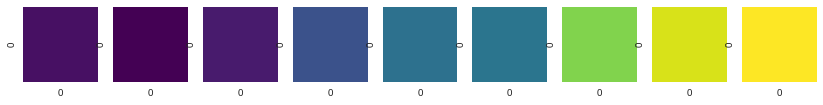

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


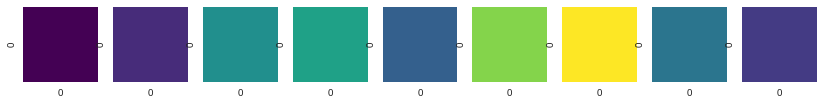

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


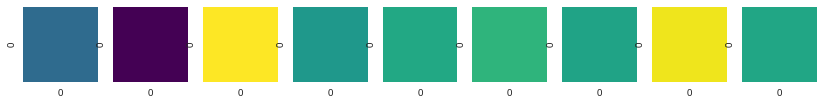

tensor(4.7665)
tensor(5.1175)
targ ID tensor([5.])
probs tensor([2.1613e-05, 1.0075e-07, 5.9816e-01, 4.0368e-04, 1.1351e-03, 2.5142e-03,
        8.4863e-04, 3.9586e-01, 1.0533e-03])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([6.9175e-04, 1.1863e-06, 2.5910e+00, 6.4328e-04, 6.6542e-04, 4.0064e-03,
        3.6760e-03, 4.6612e+00, 3.3712e-02])
tensor(5.6975)


(None, None, None)

In [101]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


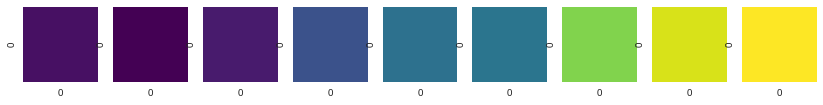

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


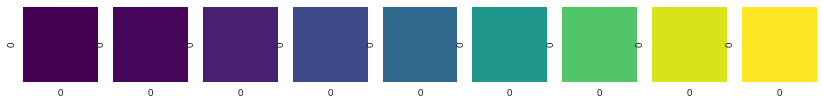

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


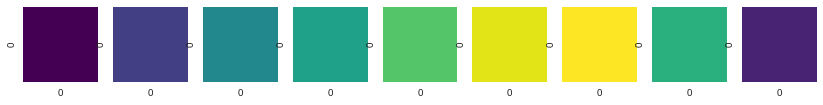

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


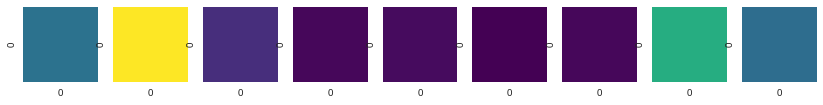

tensor(7.4503)
tensor(7.2632)
targ ID tensor([5.])
probs tensor([2.1275e-03, 9.7308e-01, 1.8723e-04, 6.1705e-05, 7.0511e-05, 5.2474e-05,
        6.3168e-05, 2.2633e-02, 1.7222e-03])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([6.8096e-02, 1.1458e+01, 8.1102e-04, 9.8329e-05, 4.1335e-05, 8.3618e-05,
        2.7363e-04, 2.6650e-01, 5.5124e-02])
tensor(7.2107)


(None, None, None)

In [102]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


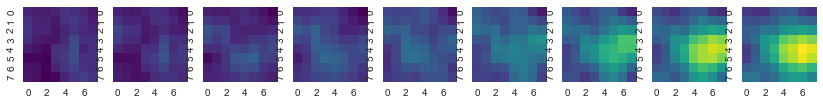

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


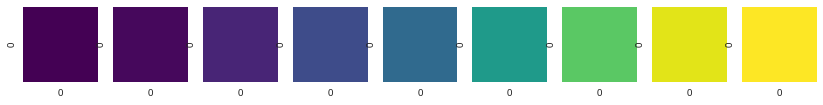

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


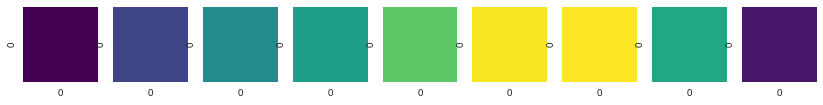

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


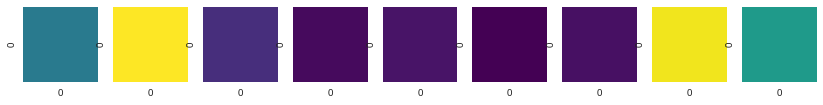

tensor(7.5974)
tensor(7.4306)
targ ID tensor([5.])
probs tensor([5.8057e-03, 5.2492e-01, 7.0813e-04, 3.1480e-04, 3.8200e-04, 2.5892e-04,
        3.4999e-04, 4.5129e-01, 1.5972e-02])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.8582e-01, 6.1808e+00, 3.0674e-03, 5.0164e-04, 2.2394e-04, 4.1260e-04,
        1.5160e-03, 5.3138e+00, 5.1123e-01])
tensor(7.2839)


(None, None, None)

In [103]:
# 3d avg Ridge max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


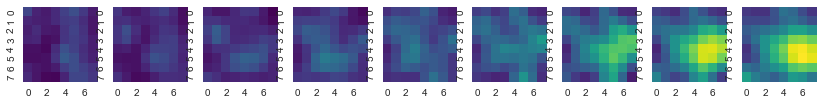

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


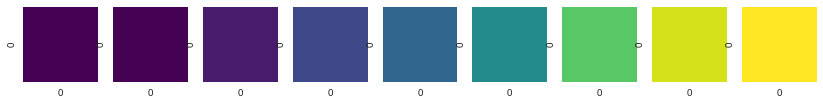

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


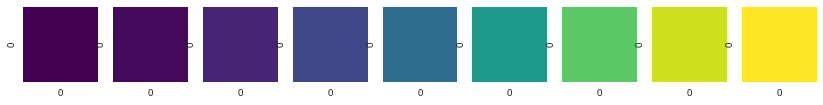

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


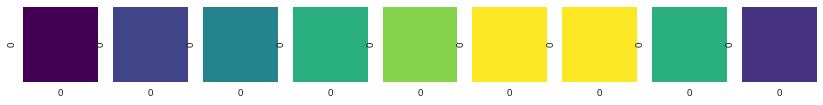

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


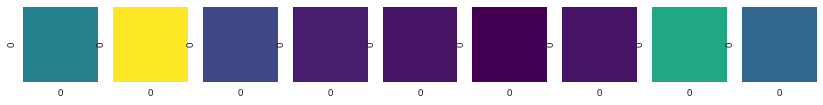

tensor(8.5066)
tensor(7.9248)
targ ID tensor([5.])
probs tensor([0.0250, 0.8791, 0.0063, 0.0026, 0.0022, 0.0016, 0.0022, 0.0682, 0.0128])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([8.0131e-01, 1.0351e+01, 2.7135e-02, 4.2019e-03, 1.2868e-03, 2.5536e-03,
        9.4349e-03, 8.0260e-01, 4.1101e-01])
tensor(7.2432)


(None, None, None)

In [104]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


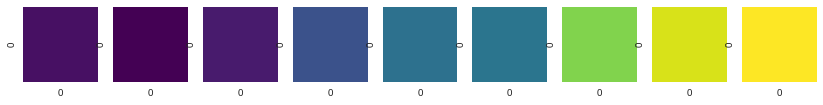

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


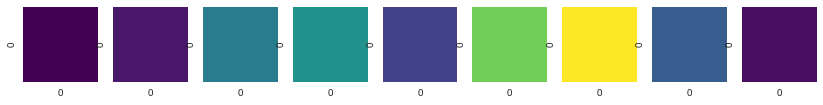

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


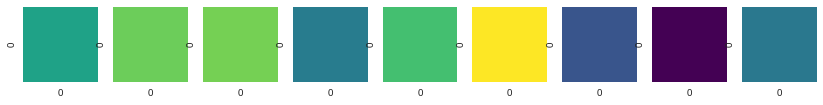

tensor(11.1021)
tensor(11.0968)
targ ID tensor([5.])
probs tensor([0.1112, 0.1115, 0.1116, 0.1109, 0.1114, 0.1120, 0.1106, 0.1101, 0.1108])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5581, 1.3133, 0.4833, 0.1767, 0.0653, 0.1784, 0.4790, 1.2964, 3.5475])
tensor(11.0921)


(None, None, None)

In [105]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


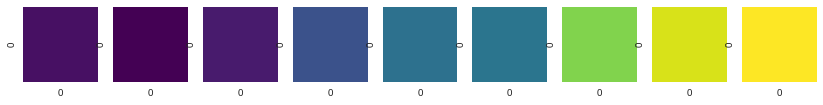

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


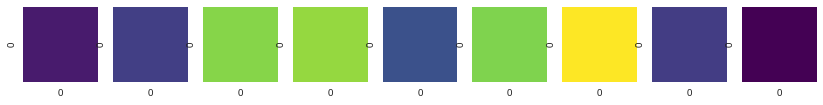

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


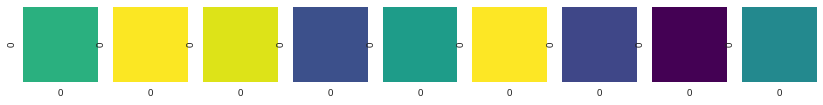

tensor(10.7615)
tensor(10.3443)
targ ID tensor([5.])
probs tensor([0.1125, 0.1636, 0.1555, 0.0752, 0.1030, 0.1644, 0.0726, 0.0583, 0.0949])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.6006, 1.9261, 0.6735, 0.1198, 0.0604, 0.2620, 0.3145, 0.6864, 3.0374])
tensor(9.9656)


(None, None, None)

In [106]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


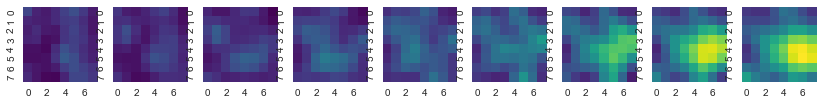

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


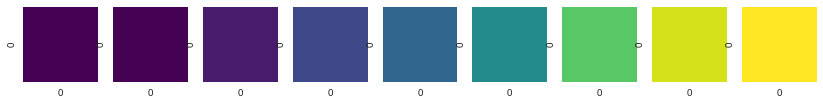

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


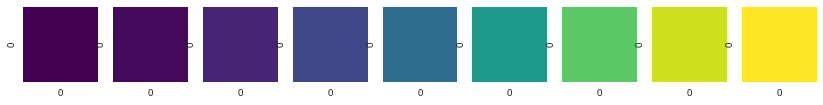

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


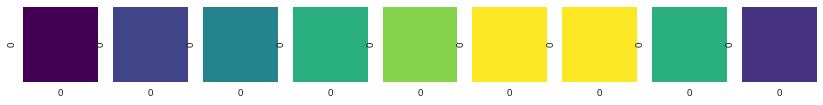

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


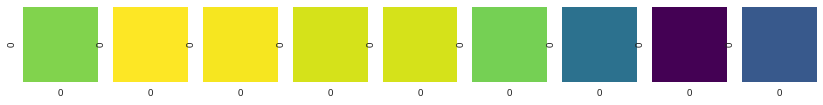

tensor(11.1063)
tensor(11.1008)
targ ID tensor([5.])
probs tensor([0.1112, 0.1114, 0.1114, 0.1113, 0.1113, 0.1112, 0.1108, 0.1105, 0.1107])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5601, 1.3117, 0.4825, 0.1774, 0.0653, 0.1772, 0.4801, 1.3011, 3.5448])
tensor(11.0954)


(None, None, None)

In [107]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


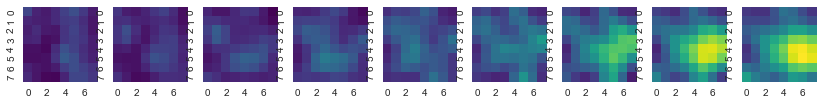

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


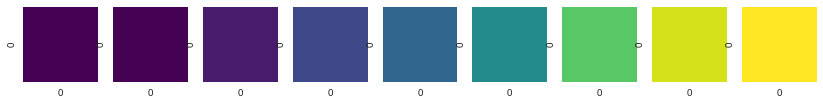

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


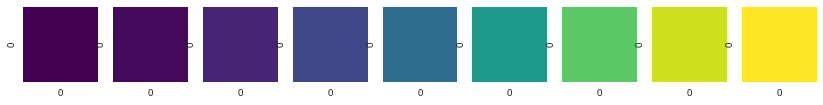

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


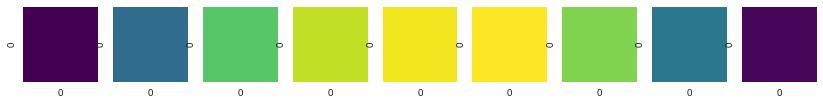

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


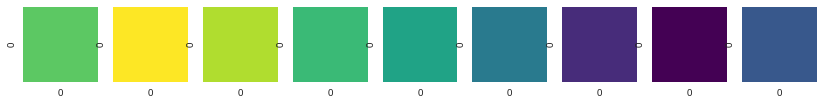

tensor(11.0822)
tensor(10.6801)
targ ID tensor([5.])
probs tensor([0.1247, 0.1446, 0.1348, 0.1197, 0.1130, 0.1021, 0.0864, 0.0804, 0.0942])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.9923, 1.7022, 0.5841, 0.1907, 0.0663, 0.1627, 0.3743, 0.9471, 3.0156])
tensor(10.2814)


(None, None, None)

In [108]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


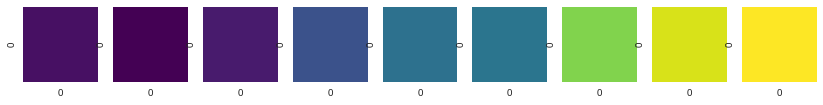

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


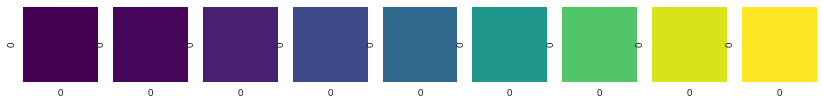

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


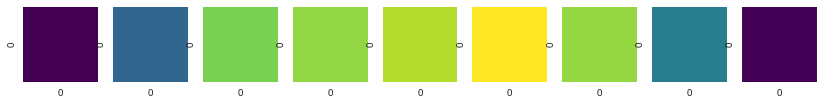

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


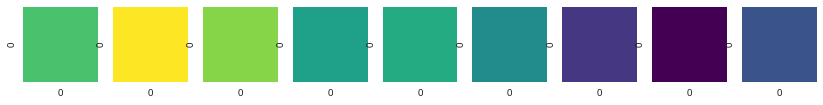

tensor(11.0624)
tensor(10.6363)
targ ID tensor([5.])
probs tensor([0.1250, 0.1526, 0.1347, 0.1126, 0.1165, 0.1065, 0.0849, 0.0761, 0.0909])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([4.0006, 1.7973, 0.5835, 0.1795, 0.0683, 0.1698, 0.3677, 0.8966, 2.9102])
tensor(10.2124)


(None, None, None)

In [109]:
# 1d avg max/min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


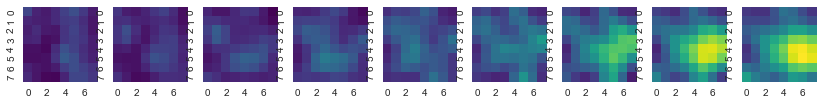

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


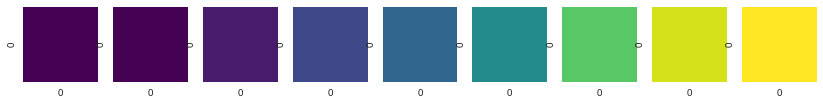

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


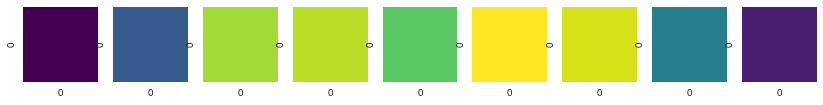

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


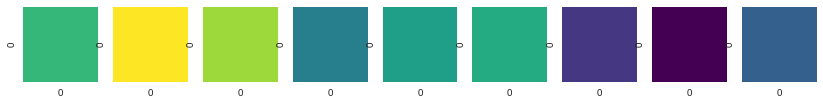

tensor(10.9428)
tensor(10.5317)
targ ID tensor([5.])
probs tensor([0.1224, 0.1605, 0.1425, 0.1011, 0.1124, 0.1172, 0.0814, 0.0715, 0.0912])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.9162, 1.8895, 0.6171, 0.1611, 0.0659, 0.1868, 0.3525, 0.8419, 2.9188])
tensor(10.1324)


(None, None, None)

In [110]:
# 3d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

## Laplacian edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


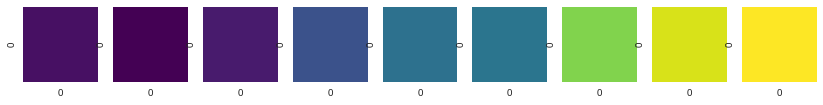

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


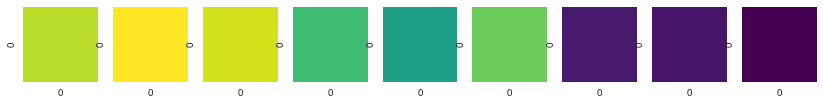

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


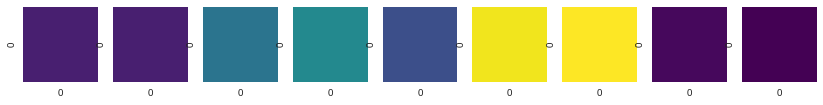

tensor(11.0738)
tensor(11.0836)
targ ID tensor([5.])
probs tensor([0.1103, 0.1103, 0.1112, 0.1114, 0.1107, 0.1130, 0.1130, 0.1101, 0.1100])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5295, 1.2984, 0.4816, 0.1776, 0.0649, 0.1800, 0.4896, 1.2963, 3.5216])
tensor(11.0940)


(None, None, None)

In [111]:
# Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


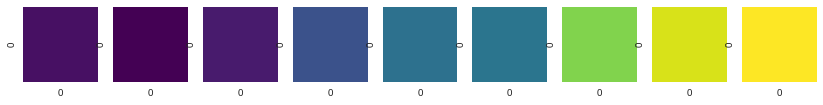

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


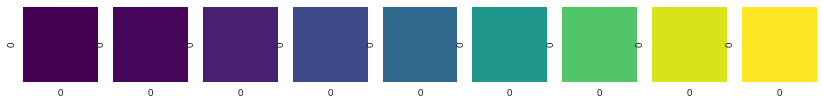

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


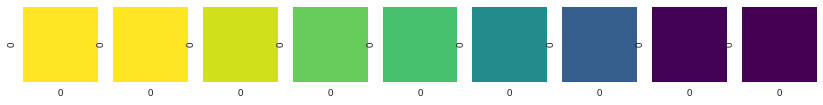

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


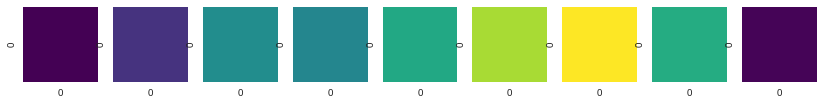

tensor(11.0645)
tensor(11.0701)
targ ID tensor([5.])
probs tensor([0.1102, 0.1105, 0.1112, 0.1111, 0.1114, 0.1119, 0.1121, 0.1114, 0.1102])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5276, 1.3011, 0.4815, 0.1770, 0.0653, 0.1783, 0.4858, 1.3117, 3.5281])
tensor(11.0762)


(None, None, None)

In [112]:
# 1d avg Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


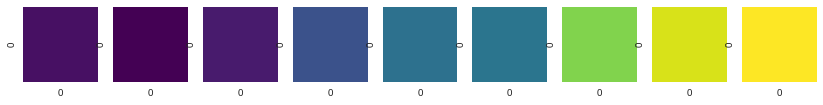

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


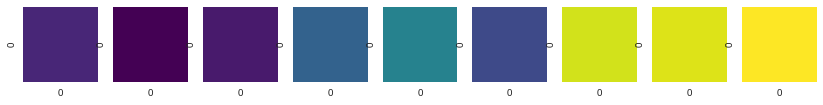

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


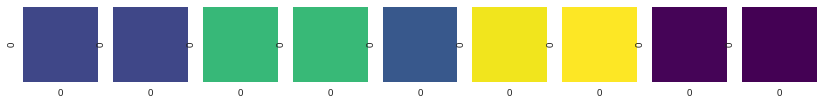

tensor(9.5182)
tensor(9.5360)
targ ID tensor([5.])
probs tensor([0.0776, 0.0776, 0.1309, 0.1314, 0.0831, 0.1860, 0.1907, 0.0617, 0.0610])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.4848, 0.9141, 0.5669, 0.2094, 0.0487, 0.2964, 0.8259, 0.7269, 1.9526])
tensor(9.5437)


(None, None, None)

In [117]:
# Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


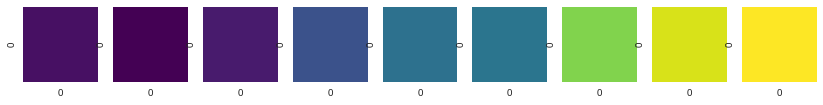

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


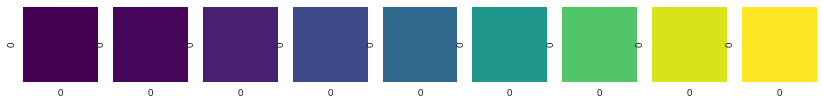

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


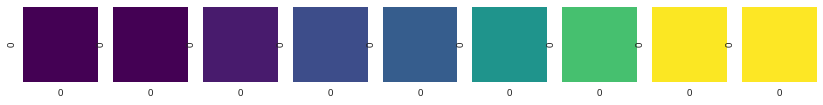

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


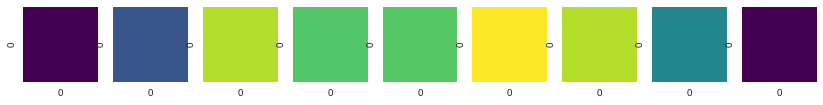

tensor(9.1128)
tensor(9.1674)
targ ID tensor([5.])
probs tensor([0.0815, 0.0939, 0.1300, 0.1197, 0.1205, 0.1382, 0.1304, 0.1041, 0.0817])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.6089, 1.1062, 0.5632, 0.1907, 0.0707, 0.2202, 0.5647, 1.2253, 2.6143])
tensor(9.2546)


(None, None, None)

In [113]:
# 1d avg Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


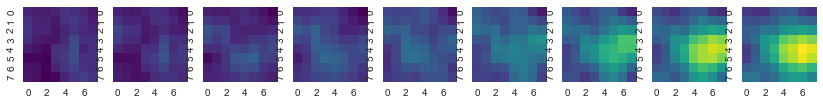

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


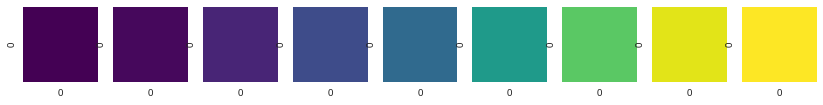

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


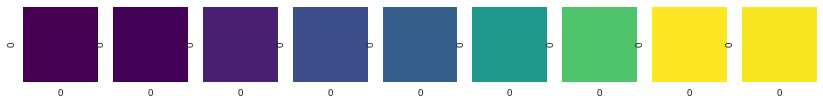

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


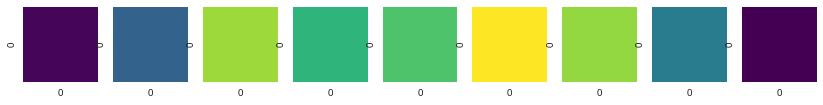

tensor(9.0604)
tensor(9.1091)
targ ID tensor([5.])
probs tensor([0.0825, 0.0969, 0.1298, 0.1163, 0.1209, 0.1405, 0.1288, 0.1023, 0.0819])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.6393, 1.1413, 0.5624, 0.1853, 0.0709, 0.2239, 0.5580, 1.2040, 2.6225])
tensor(9.1907)


(None, None, None)

In [115]:
# 3d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


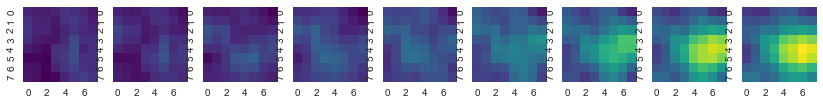

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


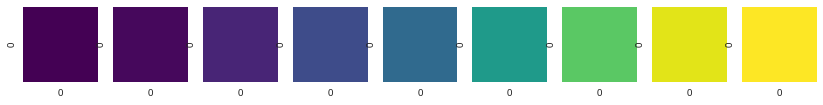

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


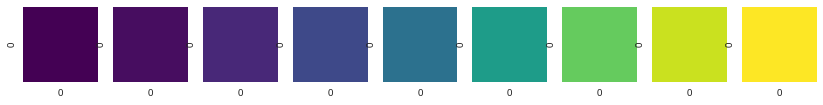

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


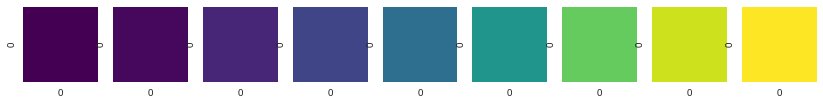

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


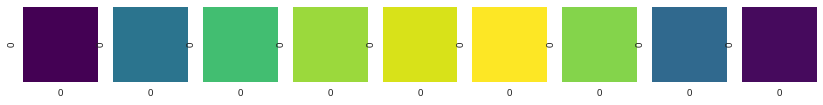

tensor(9.2339)
tensor(9.2757)
targ ID tensor([5.])
probs tensor([0.0865, 0.1019, 0.1164, 0.1241, 0.1289, 0.1324, 0.1224, 0.0999, 0.0874])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([2.7698, 1.1995, 0.5044, 0.1977, 0.0756, 0.2110, 0.5302, 1.1761, 2.7989])
tensor(9.3487)


(None, None, None)

In [116]:
# 3d avg 1d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


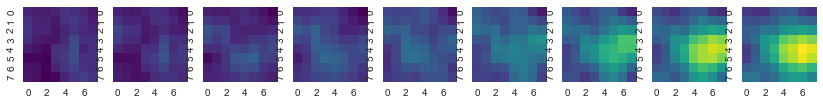

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


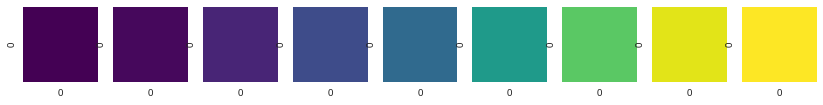

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


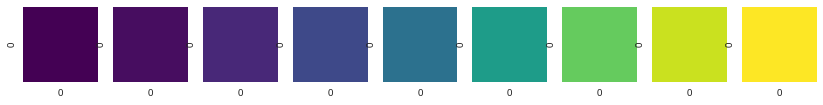

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


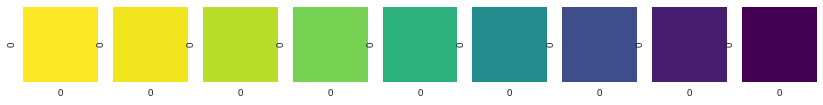

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


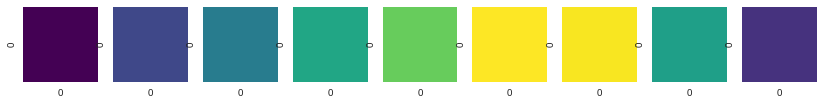

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


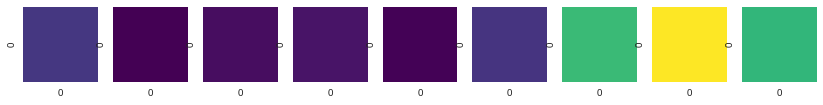

tensor(11.1212)
tensor(11.1337)
targ ID tensor([5.])
probs tensor([0.1108, 0.1105, 0.1106, 0.1106, 0.1105, 0.1108, 0.1118, 0.1125, 0.1118])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5471, 1.3013, 0.4790, 0.1763, 0.0648, 0.1766, 0.4845, 1.3244, 3.5786])
tensor(11.1458)


(None, None, None)

In [118]:
# 3d avg 1d avg Laplacian max-min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


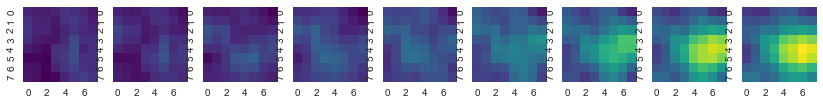

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


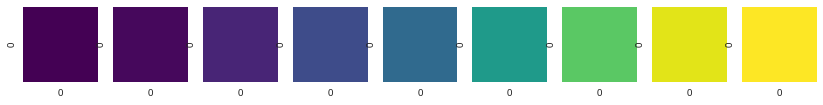

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


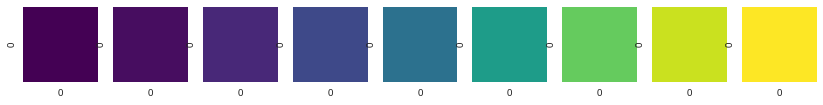

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


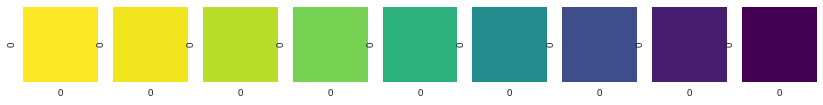

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


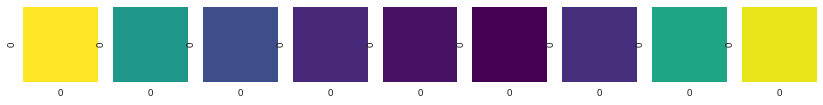

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


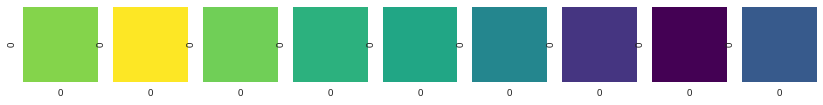

tensor(11.1941)
tensor(10.8797)
targ ID tensor([5.])
probs tensor([0.1251, 0.1359, 0.1234, 0.1158, 0.1134, 0.1070, 0.0934, 0.0873, 0.0988])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([4.0030, 1.5997, 0.5347, 0.1845, 0.0665, 0.1706, 0.4047, 1.0277, 3.1607])
tensor(10.5697)


(None, None, None)

In [119]:
# 3d avg 1d avg Laplacian max/min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


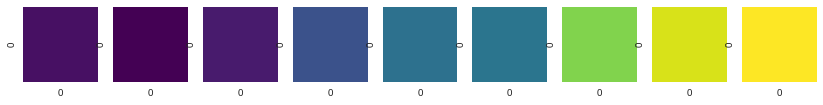

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


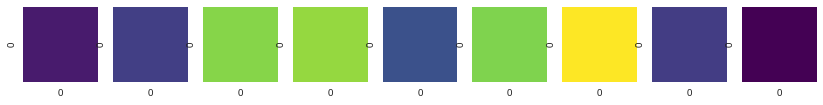

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


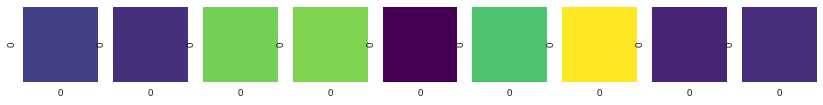

tensor(6.9073)
tensor(7.0766)
targ ID tensor([5.])
probs tensor([0.0481, 0.0431, 0.1775, 0.1844, 0.0319, 0.1516, 0.2812, 0.0396, 0.0425])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.5397, 0.5070, 0.7690, 0.2939, 0.0187, 0.2416, 1.2179, 0.4664, 1.3602])
tensor(7.2806)


(None, None, None)

In [120]:
# max/min Laplacian edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


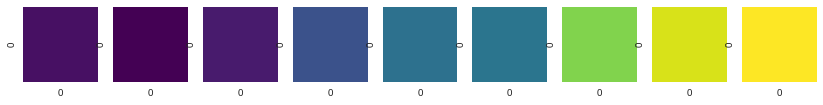

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


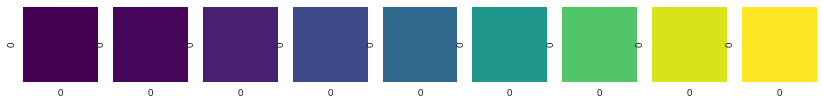

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


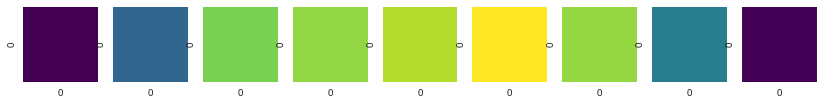

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


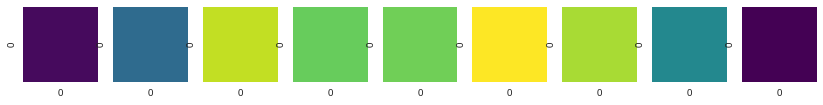

tensor(7.0307)
tensor(7.1160)
targ ID tensor([5.])
probs tensor([0.0550, 0.0791, 0.1505, 0.1285, 0.1308, 0.1674, 0.1445, 0.0909, 0.0534])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.7608, 0.9313, 0.6517, 0.2047, 0.0767, 0.2668, 0.6258, 1.0706, 1.7085])
tensor(7.2538)


(None, None, None)

In [121]:
# 1d avg max/min Laplacian edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


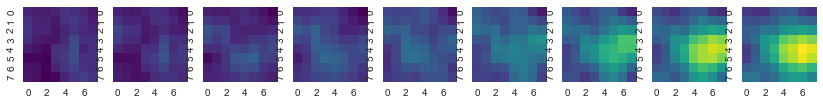

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


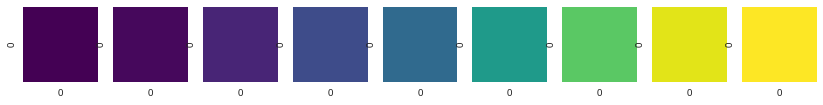

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


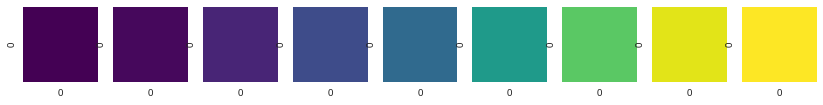

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


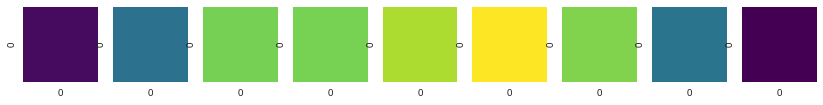

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


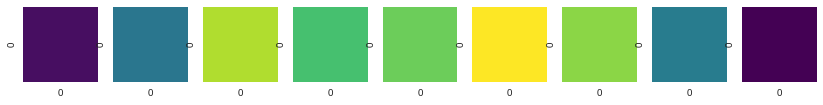

tensor(6.9407)
tensor(7.0164)
targ ID tensor([5.])
probs tensor([0.0557, 0.0848, 0.1505, 0.1221, 0.1326, 0.1730, 0.1411, 0.0870, 0.0534])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.7817, 0.9983, 0.6521, 0.1945, 0.0777, 0.2756, 0.6112, 1.0239, 1.7079])
tensor(7.1442)


(None, None, None)

In [122]:
# 3d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


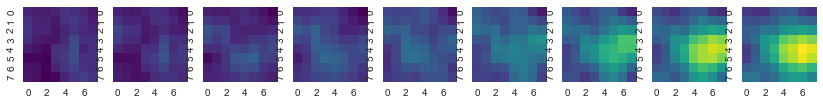

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


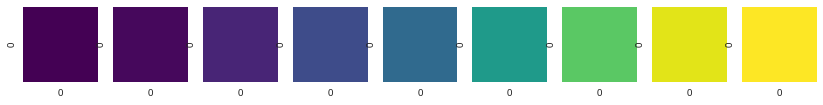

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


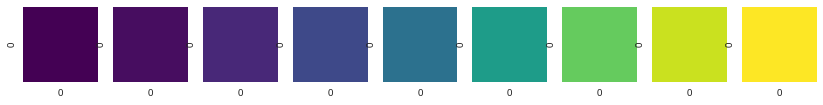

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


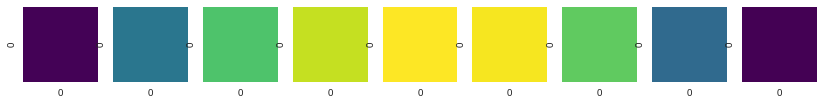

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


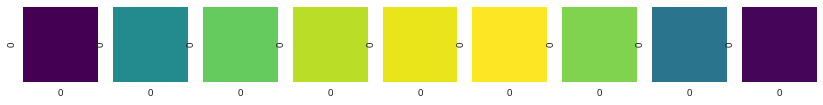

tensor(7.2889)
tensor(7.3348)
targ ID tensor([5.])
probs tensor([0.0601, 0.0941, 0.1239, 0.1405, 0.1501, 0.1550, 0.1291, 0.0864, 0.0608])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([1.9243, 1.1078, 0.5367, 0.2239, 0.0880, 0.2469, 0.5591, 1.0172, 1.9469])
tensor(7.4275)


(None, None, None)

In [123]:
# 3d avg 1d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


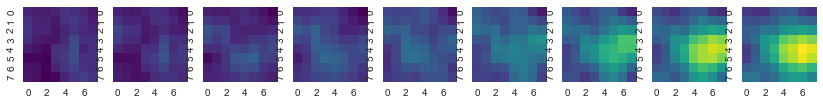

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


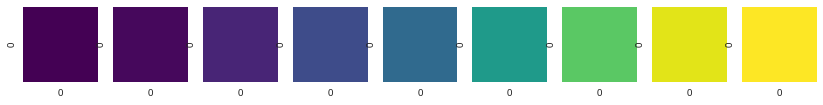

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


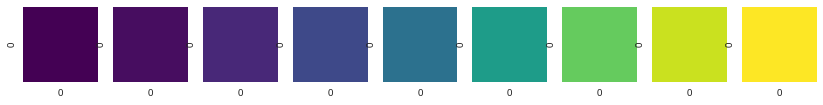

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


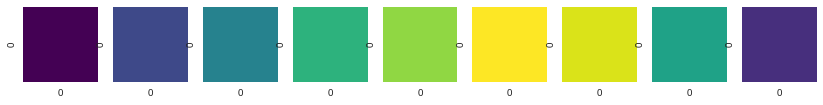

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


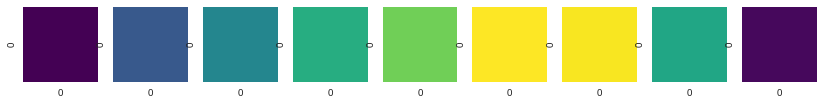

tensor(11.0610)
tensor(11.0641)
targ ID tensor([5.])
probs tensor([0.1102, 0.1107, 0.1110, 0.1113, 0.1115, 0.1119, 0.1119, 0.1112, 0.1103])
ints tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
mses tensor([32.0070, 11.7747,  4.3317,  1.5935,  0.5862,  1.5935,  4.3317, 11.7747,
        32.0070])
int losses tensor([3.5284, 1.3033, 0.4808, 0.1773, 0.0654, 0.1783, 0.4846, 1.3096, 3.5295])
tensor(11.0679)


(None, None, None)

In [124]:
# 3d avg 1d avg max-min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs, pred_start=-1), score_data(x, targs, pred_start=0), score_data(x, targs, pred_start=1, test_id=test_id)